# Install Packages

https://github.com/LJS-Student/pytorch-GAT/blob/main/The%20Annotated%20GAT%20(Cora).ipynb

In [5]:
import pickle

import matplotlib.pyplot as plt
import networkx as nx
#import igraph as ig

import scipy.sparse as sp
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter

import os
import enum

In [6]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"
device = torch.device("cuda:3" if torch.cuda.is_available() else 'cpu')
print(device)

cuda:3


In [7]:
class DatasetType(enum.Enum):
    CORA = 0

class GraphVisualizationTool(enum.Enum):
    NETWROKX = 0,
    IGRAPH = 1

In [8]:
DATA_DIR_PATH = os.path.join(os.getcwd(), 'data')
CORA_PATH = os.path.join(DATA_DIR_PATH, 'cora')

# Thomas Kipf et al. first used this split in GCN paper and later Petar Veličković et al. in GAT paper
CORA_TRAIN_RANGE = [0, 140]  # we're using the first 140 nodes as the training nodes
CORA_VAL_RANGE = [140, 140+500]
CORA_TEST_RANGE = [1708, 1708+1000]
CORA_NUM_INPUT_FEATURES = 1433
CORA_NUM_CLASSES = 7

# Used whenever we need to visualzie points from different classes (t-SNE, CORA visualization)
cora_label_to_color_map = {0: "red", 1: "blue", 2: "green", 3: "orange", 4: "yellow", 5: "pink", 6: "gray"}

# 1. Understanding Data

## 1.1 Dataset 보기

In [9]:

# First let's define these simple functions for loading/saving Pickle files - we need them for Cora

# All Cora data is stored as pickle
def pickle_read(path):
    with open(path, 'rb') as file:
        data = pickle.load(file)
    
    return data

def pickle_save(path, data):
    with open(path, 'wb') as file:
        pickle.dump(data, file, protocol=pickle.HIGHEST_PROTOCOL)

In [10]:
node_feature_csr = pickle_read(os.path.join(CORA_PATH, 'node_features.csr'))
node_labels_npy = pickle_read(os.path.join(CORA_PATH, 'node_labels.npy'))
adjacency_list_dict = pickle_read(os.path.join(CORA_PATH, 'adjacency_list.dict'))

In [11]:
# Node_feautre.csr Dataset
print("원래 Matrix의 shape : {}".format(node_feature_csr.shape)) # 2708 x 1433(cora dataset node의 attribute)
print("csr로 표현된 row : {}".format(node_feature_csr.indptr)) # csr형식
print("csr(coo)로 표현된 col : {}".format(node_feature_csr.indices)) # csr형식
print("attribute의 값 : {}".format(node_feature_csr.data)) # 모두 1로 되어있음


원래 Matrix의 shape : (2708, 1433)
csr로 표현된 row : [    0     9    32 ... 49189 49203 49216]
csr(coo)로 표현된 col : [  19   81  146 ... 1328 1412 1414]
attribute의 값 : [1. 1. 1. ... 1. 1. 1.]


In [12]:
# Node_labels.npy Dataset
print("label의 shape : {}".format(node_labels_npy.shape))
print("label의 값 : {}".format(node_labels_npy))


label의 shape : (2708,)
label의 값 : [3 4 4 ... 3 3 3]


In [13]:
# adjacency_list_dict Dataset
print(len(adjacency_list_dict.keys())) # 모든 node
print(len(adjacency_list_dict.values())) # 각 노드마다 연결된 node의 list가 value로 있음

2708
2708


## 1.2 Load Dataset

In [14]:
def load_graph_data(training_config, device):
    dataset_name = training_config['dataset_name'].lower()
    should_visualize = training_config['should_visualize']

    if dataset_name == DatasetType.CORA.name.lower():

        # shape = (N, FIN), where N is the number of nodes and FIN is the number of input features
        node_features_csr = pickle_read(os.path.join(CORA_PATH, 'node_features.csr')) # 들어올 때 부터 data가 csr타입임

        # shape = (N, 1)
        node_labels_npy = pickle_read(os.path.join(CORA_PATH, 'node_labels.npy'))

        # shape = (N, number of neighboring nodes) <- this is a dictionary not a matrix!
        adjacency_list_dict = pickle_read(os.path.join(CORA_PATH, 'adjacency_list.dict'))

        # Normalize the features (helps with training)
        # Graph Sampling을 안하니까 미리 해둬도 됨
        node_features_csr = normalize_features_sparse(node_features_csr) 
        num_of_nodes = len(node_labels_npy)       

        # shape = (2, E), where E is the number of edges, and 2 for source and target nodes. Basically edge index
        # contains tuples of the format S->T, e.g. 0->3 means that node with id 0 points to a node with id 3.
        topology = build_edge_index(adjacency_list_dict, num_of_nodes, add_self_edges=True)

        # Note : topology is just a fancy way of naming the graph structure data

        if should_visualize:
            plot_in_out_degree_distributions(topology, num_of_nodes, dataset_name)
            visualize_graph(topology, node_labels_npy, dataset_name)

        # Convert to dense Pytorch tensors

        # Needs to be long int type because later functions like PyTorch's index_select expect it
        # Needs to be long int type because later functions like PyTorch's index_select expect it
        topology = torch.tensor(topology, dtype=torch.long, device=device)
        node_labels = torch.tensor(node_labels_npy, dtype=torch.long, device=device)  # Cross entropy expects a long int
        node_features = torch.tensor(node_features_csr.todense(), device=device)

        # Indices that help us extract nodes that belong to the train/val and test splits
        train_indices = torch.arange(CORA_TRAIN_RANGE[0], CORA_TRAIN_RANGE[1], dtype=torch.long, device=device)
        val_indices = torch.arange(CORA_VAL_RANGE[0], CORA_VAL_RANGE[1], dtype=torch.long, device=device)
        test_indices = torch.arange(CORA_TEST_RANGE[0], CORA_TEST_RANGE[1], dtype=torch.long, device=device)

        return node_features, node_labels, topology, train_indices, val_indices, test_indices
    else:
        raise Exception(f'{dataset_name} not yet supported.')


In [15]:
# Normalize [1, 0, 1, 0, 1] -> [0.33, 0, 0.33, 0, 0.33]
def normalize_features_sparse(node_features_sparse):
    assert sp.issparse(node_features_sparse), f'Expected a sparse matrix, got {node_features_sparse}.' # Sparse Matrix형식인지 확인

    node_features_sum = np.array(node_features_sparse.sum(-1)) # node마다(row마다) 1이 몇개있는지 다 더함
    node_features_inv_sum = np.power(node_features_sum, -1).squeeze() # 역수를 취함
    node_features_inv_sum[np.isinf(node_features_inv_sum)] = 1. # feature가 하나도 없는 노드의 합에 1를 채워넣음
    diagonal_inv_features_sum_matrix = sp.diags(node_features_inv_sum)

    return diagonal_inv_features_sum_matrix.dot(node_features_sparse)

In [16]:
# array([[   0,    0,    0, ..., 2705, 2706, 2707],
#       [ 633, 1862, 2582, ..., 2705, 2706, 2707]]) 를 만듬
def build_edge_index(adjacency_list_dict, num_of_nodes, add_self_edges=True):
    source_nodes_ids, target_nodes_ids = [], []
    seen_edges = set()

    for src_node, neighboring_nodes in adjacency_list_dict.items():
        for trg_node in neighboring_nodes:
            # if this edge hasn't been seen so far we add it to the edge index (coalescing - removing duplicates)
            if (src_node, trg_node) not in seen_edges:  # it'd be easy to explicitly remove self-edges (Cora has none..)
                source_nodes_ids.append(src_node)
                target_nodes_ids.append(trg_node)

                seen_edges.add((src_node, trg_node))

    if add_self_edges:
        source_nodes_ids.extend(np.arange(num_of_nodes))
        target_nodes_ids.extend(np.arange(num_of_nodes))

    # shape = (2, E), where E is the number of edges in the graph
    edge_index = np.row_stack((source_nodes_ids, target_nodes_ids))

    return edge_index


In [17]:
# Let's just define dummy visualization functions for now - just to stop Python interpreter from complaining!
# We'll define them in a moment, properly, I swear.

def plot_in_out_degree_distributions():
    pass

def visualize_graph():
    pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # checking whether you have a GPU

config = {
    'dataset_name': DatasetType.CORA.name,
    'should_visualize': False
}

node_features, node_labels, edge_index, train_indices, val_indices, test_indices = load_graph_data(config, device)

print(node_features.shape, node_features.dtype)
print(node_labels.shape, node_labels.dtype)
print(edge_index.shape, edge_index.dtype)
print(train_indices.shape, train_indices.dtype)
print(val_indices.shape, val_indices.dtype)
print(test_indices.shape, test_indices.dtype)

torch.Size([2708, 1433]) torch.float32
torch.Size([2708]) torch.int64
torch.Size([2, 13264]) torch.int64
torch.Size([140]) torch.int64
torch.Size([500]) torch.int64
torch.Size([1000]) torch.int64


# Visualizing

In [18]:
def plot_in_out_degree_distributions(edge_index, num_of_nodes, dataset_name):
    """
        Note: It would be easy to do various kinds of powerful network analysis using igraph/networkx, etc.
        I chose to explicitly calculate only the node degree statistics here, but you can go much further if needed and
        calculate the graph diameter, number of triangles and many other concepts from the network analysis field.

    """

    if isinstance(edge_index, torch.Tensor): # Tensor -> Numpy
        edge_index = edge_index.cpu().numpy()

    assert isinstance(edge_index, np.ndarray), f'Expected NumPy array got {type(edge_index)}.' # numpy의 array type인지 check

    # Store each node's input and output degree
    in_degrees = np.zeros(num_of_nodes, dtype=np.int) # in_degree를 저장할 array를 만듬
    out_degrees = np.zeros(num_of_nodes, dtype=np.int) # out_degree를 저장할 array를 만듬

    # Edge Index shape = (2, E), the first row contains the source nodes, the second target/sink nodes
    # Note on terminology: source nodes point to target/sink nodes
    # edge마다 돌면서 node에 Degree를 채워넣음
    num_of_edges = edge_index.shape[1]
    for cnt in range(num_of_edges):
        source_node_id = edge_index[0, cnt]
        target_node_id = edge_index[1, cnt]

        out_degrees[source_node_id] += 1
        in_degrees[target_node_id] += 1

    # 해당 out degree를 가진 node의 갯수를 체크
    hist = np.zeros(np.max(out_degrees)+1)
    for out_degree in out_degrees:
        hist[out_degree] += 1

    fig = plt.figure(figsize=(12, 8), dpi=100)
    fig.subplots_adjust(hspace=0.6)

    plt.subplot(311)
    plt.plot(in_degrees, color='red')
    plt.xlabel('node_id'); plt.ylabel('in-degree count'); plt.title('Input degree for different node ids')

    plt.subplot(312)
    plt.plot(out_degrees, color='green')
    plt.xlabel('node id'); plt.ylabel('out-degree count'); plt.title('Out degree for different node ids')

    plt.subplot(313)
    plt.plot(hist, color='blue')
    plt.xlabel('node degree')
    plt.ylabel('# nodes for a given out-degree')
    plt.title(f'Node out-degree distribution for {dataset_name} dataset')
    plt.xticks(np.arange(0, len(hist), 5.0))

    plt.grid(True)
    plt.show()


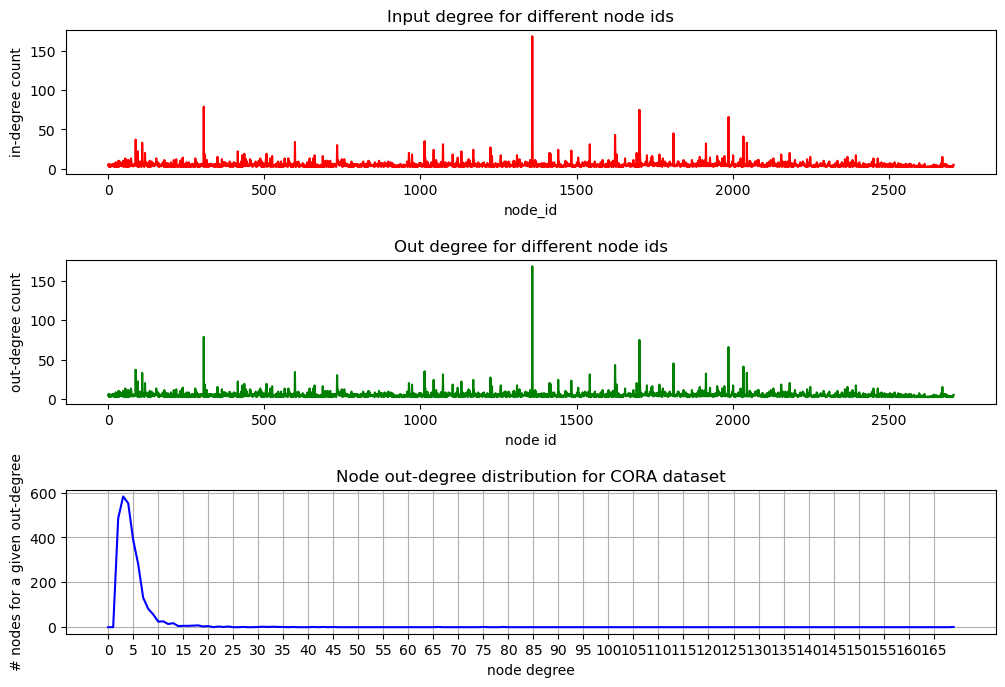

In [19]:
num_of_nodes = len(node_labels)
plot_in_out_degree_distributions(edge_index, num_of_nodes, config['dataset_name'])

In [20]:
# CORA는 Undirected Graph 이므로 in_degree와 out_degree가 일치함
# 몇몇 노드는 degree가 정말 크지만 대부분의 node는 degree가 작음(보통 2~5)


# GAT

In [21]:
class GAT(nn.Module):

    def __init__(self, num_of_layers, num_heads_per_layer, num_features_per_layer, add_skip_connection=True, bias=True,
                dropout=0.6, log_attention_weights=False):
        """
        Args:
            num_of_layers(int) : GAT layer의 갯수
            num_heads_per_layer : 한 GAT Layer에 몇개의 head가 있는지(Multi-head Attention)
            num_features_per_layer : 한 GAT Layer에 몇개의 feature가 있는지
            add_skip_connection(boolean) : skip_connection 연결을 할 건지 
            bias(boolean) : bias사용 할건지
            dropout(float) : dropout 확률
            log_attention_weights(boolean) : attention weight를 기록할건지
        """
        super().__init__()
        
        # 각layer에서 multi-head attention이 걸리는거니까 같아야되고 마지막에 분류를 위해서 Softmax Layer가 필요하기때문에 num_features_per_layer는 +1
        assert num_of_layers == len(num_heads_per_layer) == len(num_features_per_layer) - 1, f'Enter valid arch params.' # Why??? - List의 Length임

        num_heads_per_layer = [1] + num_heads_per_layer  # trick - so that I can nicely create GAT layers below - Why?? - 첫 input Layer는 attention이 없음


        gat_layers = []
        for i in range(num_of_layers):
            layer = GATLayer(
                num_in_features = num_features_per_layer[i] * num_heads_per_layer[i], # input feature의 수는 (해당layer(head한개)의 feature수) * (head의 수)
                num_out_features = num_features_per_layer[i+1], # output feature의 수는 다음 input feature의 수와 동일
                num_of_heads = num_heads_per_layer[i+1],
                concat=True if i < num_of_layers -1 else False, # 마지막 layer에서는 concat을 안하고 mean avg를 한다
                activation = nn.ELU() if i < num_of_layers - 1 else None, # 마지막 layer에서는 그냥 output을 낸다
                dropout_prob=dropout,
                add_skip_connection=add_skip_connection,
                bias=bias,
                log_attention_weights=log_attention_weights
            )
            gat_layers.append(layer)

        self.gat_net = nn.Sequential(
            *gat_layers,
        )

    def forward(self, data):
        return self.gat_net(data)




In [22]:
class GATLayer(nn.Module):
    
    # 여러 function에서 사용되므로 미리 정의
    src_nodes_dim = 0  # edge index에서 source node의 position
    trg_nodes_dim = 1  # edge index에서 target node의 position

    nodes_dim = 0      # node의 dim
    head_dim = 1       # attention head의 dim

    def __init__(self, num_in_features, num_out_features, num_of_heads, concat=True, activation=nn.ELU(),
                dropout_prob=0.6, add_skip_connection=True, bias=True, log_attention_weights=False):

        super().__init__()

        self.num_of_heads = num_of_heads # head의 수(multi-head attention)
        self.num_out_features = num_out_features # out-feature 수
        self.concat = concat
        self.add_skip_connection = add_skip_connection

        # Trainable weights: linear projection matrix (denoted as "W" in the paper), attention target/source
        # (denoted as "a" in the paper) and bias (not mentioned in the paper but present in the official GAT repo)
        
        # 논문에서 W(attention head마다 다른 W가 필요하지만 이런식으로 나타낼 수 있음) 
        self.linear_proj = nn.Linear(num_in_features, num_of_heads * num_out_features, bias=False)

        # 논문에서 a
        # 논문에서는 attention coefficient를 구할 때 concat한뒤 a와 곱해주는데 구현할때는
        # [x(source), a_left]를 따로 곱해주고 [y(target), a_right]를 따로 곱해준뒤 더해주는 식으로 구현
        self.scoring_fn_target = nn.Parameter(torch.Tensor(1, num_of_heads, num_out_features)) # (1, NH, FOUT)
        self.scoring_fn_source = nn.Parameter(torch.Tensor(1, num_of_heads, num_out_features)) # (1, NH, FOUT)

        # Bias is definitely not crucial to GAT - feel free to experiment (I pinged the main author, Peter, on this one)
        if bias and concat:
            self.bias = nn.Parameter(torch.Tensor(num_of_heads * num_out_features))
        elif bias and not concat:
            self.bias = nn.Parameter(torch.Tensor(num_out_features))
        else:
            self.register_parameter('bias', None)
        if add_skip_connection:
            self.skip_proj = nn.Linear(num_in_features, num_of_heads * num_out_features, bias=False)
        else:
            self.register_parameter('skip_proj', None)
        
        #
        # End of trainable weights
        #

        self.leakyReLU = nn.LeakyReLU(0.2)
        self.activation = activation
        self.dropout = nn.Dropout(p=dropout_prob)

        self.log_attention_weights = log_attention_weights
        self.attention_weights = None

        self.init_params()

    def forward(self, data):
        #
        # Step 1: Linear Projection + regularization
        # 

        in_nodes_features, edge_index = data # (N, FIN), (2, E)
        num_of_nodes = in_nodes_features.shape[self.nodes_dim] # node의 수(scalar N) 위에서 nodes_dim = 0로 정의하였음
        assert edge_index.shape[0] == 2, f'Expected edge index with shape=(2,E) got {edge_index.shape}'

        in_nodes_features = self.dropout(in_nodes_features) # epoch마다 Node feature 몇개식을 Drop out 시킴

        # linear_proj : (FIN, NH*FOUT)
        nodes_features_proj = self.linear_proj(in_nodes_features).view(-1, self.num_of_heads, self.num_out_features) # (N, NH, FOUT)모든 node에 W Matrix를 곱해준 것
        nodes_features_proj = self.dropout(nodes_features_proj) # 여기서도 dropout을 걸어줌

        #
        # Step 2: Edge attention calculation
        #


        # *는 element-wise product임(Hadamard product)
        # broadcasting이 된다 (N, NH, FOUT) * (1, NH, FOUT) -> (N, NH, 1)
        # sum을 하면 (N, NH, 1) -> (N, NH) sum은 마지막 dimension을 squueze해줌
        # output은 논문 기준으로 Wh까지 한 것
        scores_source = (nodes_features_proj * self.scoring_fn_source).sum(dim=-1) # a를 source에 곱해줌 (N, NH)
        scores_target = (nodes_features_proj * self.scoring_fn_target).sum(dim=-1) # a를 target에 곱해줌 (N, NH)


        # attention(e_ij)은 edge에 걸린다 생각할 수 있으므로 scores shpae : (N, NH) -> (E, NH)로 proj matrix도 (N, NH, FOUT) -> (E, NH, FOUT)로 보냄
        scores_source_lifted, scores_target_lifted, nodes_features_proj_lifted = self.lift(scores_source, scores_target, nodes_features_proj, edge_index)


        # 따로 계산한 것을 더해주고 leakyReLU(non-linearlity)에 넣음
        scores_per_edge = self.leakyReLU(scores_source_lifted + scores_target_lifted) # (E, NH)

        # attention coefficient를 normalize해줌
        # 논문에서 alpha
        # shape = (E, NH, 1)
        attentions_per_edge = self.neighborhood_aware_softmax(scores_per_edge, edge_index[self.trg_nodes_dim], num_of_nodes)

        # neighborhood aggregation를 stochastic하게
        attentions_per_edge = self.dropout(attentions_per_edge)


        #
        # Step 3: Neighborhood aggregation
        #

        # *는 Element-wise product(torch.mul과 동일)
        
        # (E, NH, FOUT) * (E, NH, 1) -> (E, NH, FOUT)
        nodes_features_proj_lifted_weighted = nodes_features_proj_lifted * attentions_per_edge

        # 구해둔 edge별 message를 각각의 target node에 aggregation해줌
        # shape = (N, NH, FOUT)
        out_nodes_features = self.aggregate_neighbors(nodes_features_proj_lifted_weighted, edge_index, in_nodes_features, num_of_nodes) # (N, NH, FOUT)



        #
        # Step4: Residual/skip connections, concat and bias
        #


        out_nodes_features = self.skip_concat_bias(attentions_per_edge, in_nodes_features, out_nodes_features)
        
        return (out_nodes_features, edge_index)



    # Edge별 Softmax값 계산
    def neighborhood_aware_softmax(self, scores_per_edge, trg_index, num_of_nodes):
        """
        Input : scores_per_edge : (E, NH)
                trg_index       :  (E)
                num_of_nodes    :  N
        """
        scores_per_edge = scores_per_edge - scores_per_edge.max() # 이건 왜 빼지?? Normalize라고 생각하면 되는건가... (E, NH)
        exp_scores_per_edge = scores_per_edge.exp() # softmax (E, NH)

        # 각각의 Edge의 분모값을 계산하여 저장 (E, NH)
        neighborhood_aware_denominator = self.sum_edge_scores_neighborhood_aware(exp_scores_per_edge, trg_index, num_of_nodes)

        # Softmax 계산
        attentions_per_edge = exp_scores_per_edge / (neighborhood_aware_denominator + 1e-16)

        return attentions_per_edge.unsqueeze(-1) # (E, NH, 1)


    # Edge별 Softmax 분모의 합을 구하기 위함
    def sum_edge_scores_neighborhood_aware(self, exp_scores_per_edge, trg_index, num_of_nodes):
        """
        Input : exp_scores_per_edge : (E, NH)
                trg_index           : (E)
                num_of_nodes        : N
        """

        # exp_scores_per_edge와 shape을 맞춰야함(scatter_add_ 에 필요)
        trg_index_broadcasted = self.explicit_broadcast(trg_index, exp_scores_per_edge) # E -> (E, NH)

        # shape = (N, NH)
        size = list(exp_scores_per_edge.shape)
        size[self.nodes_dim] = num_of_nodes # (E, NH) -> (N, NH) nodes_dim = 0으로 정의되어 있음
        neighborhood_sums = torch.zeros(size, dtype=exp_scores_per_edge.dtype, device=exp_scores_per_edge.device) # (N, NH) 빈 tensor

        # nodes_dim = 0 -> 열방향 
        # node마다 들어오는 attention의 총 합을 (N, NH)로 저장하기 위함
        neighborhood_sums.scatter_add_(self.nodes_dim, trg_index_broadcasted, exp_scores_per_edge) # (N, NH)

        return neighborhood_sums.index_select(self.nodes_dim, trg_index) # (E, NH) edge의 attention의 분모값을 저장



    # dimension을 맞춰주기 위한 함수
    def explicit_broadcast(self, this, other):
        # this와 other의 dimension이 맞아질 때 까지 this를 unqueeze 해줌(dimension이 1씩 늘어남)
        # (E) -> (E, 1)
        for _ in range(this.dim(), other.dim()):
            this = this.unsqueeze(-1)

        # other와 shape이 같아질 때 까지 this에 같은 값으로 열을 늘림
        # (E, 1) -> (E, NH)
        return this.expand_as(other)



    # aggregation을 한다
    def aggregate_neighbors(self, nodes_features_proj_lifted_weighted, edge_index, in_nodes_features, num_of_nodes):
        """
        Input : nodes_features_proj_lifted_weighted : (E, NH, FOUT)
                edge_index                          : (2, EH)
                in_nodes_features                   : (N, FIN)
                num_of_nodes                        : N
        """
        
        size = list(nodes_features_proj_lifted_weighted.shape)
        size[self.nodes_dim] = num_of_nodes # (N, NH, FOUT)
        out_nodes_features = torch.zeros(size, dtype=in_nodes_features.dtype, device=in_nodes_features.device)

        # shape = (E) -> (E, NH, FOUT)
        trg_index_broadcasted = self.explicit_broadcast(edge_index[self.trg_nodes_dim], nodes_features_proj_lifted_weighted)

        # aggregation
        # (E, NH, FOUT) -> (N, NH, FOUT)
        out_nodes_features.scatter_add_(self.nodes_dim, trg_index_broadcasted, nodes_features_proj_lifted_weighted)

        return out_nodes_features



    # Node에 대해 score가 매겨져 있는 것을 Edge로 옮겨줌(lift)
    def lift(self, scores_source, scores_target, nodes_features_matrix_proj, edge_index):
        
        src_nodes_index = edge_index[self.src_nodes_dim] # edge_index의 윗 행 shape : (1, E)     src_nodes_dim은 0으로 위에 정의했음
        trg_nodes_index = edge_index[self.trg_nodes_dim] # edge_index의 아래 행 shape : (1, E)   trg_nodes_dim은 1으로 위에 정의했음

        # index_select를 쓰면 scores_source[src_nodes_index]보다 빠름
        # scores_source는 input으로 들어올때는 (N, NH) -> 여기서 (E, NH)로 바뀜,   socres_target도 마찬가지
        # nodes_features_proj(nodes_feautres_matrix_proj)도 (N, NH, FOUT) -> (E, NH, FOUT)
        scores_source = scores_source.index_select(self.nodes_dim, src_nodes_index) # (E, NH) 
        scores_target = scores_target.index_select(self.nodes_dim, trg_nodes_index) # (E, NH)
        nodes_features_matrix_proj_lifted = nodes_features_matrix_proj.index_select(self.nodes_dim, src_nodes_index) # (E, NH, FOUT)

        return scores_source, scores_target, nodes_features_matrix_proj_lifted


    # parameter initialize
    def init_params(self):
        """
        The reason we're using Glorot (aka Xavier uniform) initialization is because it's a default TF initialization:
            https://stackoverflow.com/questions/37350131/what-is-the-default-variable-initializer-in-tensorflow

        The original repo was developed in TensorFlow (TF) and they used the default initialization.
        Feel free to experiment - there may be better initializations depending on your problem.

        """
        nn.init.xavier_uniform_(self.linear_proj.weight)
        nn.init.xavier_uniform_(self.scoring_fn_target)
        nn.init.xavier_uniform_(self.scoring_fn_source)

        if self.bias is not None:
            torch.nn.init.zeros_(self.bias)

    # skip-connection
    def skip_concat_bias(self, attention_coefficients, in_nodes_features, out_nodes_features):
        
        if self.log_attention_weights: # potentially log for later visualization in playground.py
            self.attention_weights = attention_coefficients

        
        if self.add_skip_connection: # add skip or residual connection
            if out_nodes_features.shape[-1] == in_nodes_features.shape[-1]: # if FIN == FOUT
                # unsqueeze does this: (N, FIN) -> (N, 1, FIN), out features are (N, NH, FOUT) so 1 gets broadcast to NH
                # thus we're basically copying input vectors NH times and adding to precessed vectors
                out_nodes_features += in_nodes_features.unsqueeze(1)
            else:
                # FIN != FOUT so we need to project input feature vectors into dimension that can be added to output
                # feature vectors. skip_proj adds lots of additional capacity which may cause overfitting.
                out_nodes_features += self.skip_proj(in_nodes_features).view(-1, self.num_of_heads, self.num_out_features)


        if self.concat: # 마지막 Layer에서만 concat안함
            # shape = (N, NH, FOUT) -> (N, NH*FOUT)
            out_nodes_features = out_nodes_features.view(-1, self.num_of_heads * self.num_out_features)
        else:
            # shape = (N, NH, FOUT) -> (N, FOUT)
            out_nodes_features = out_nodes_features.mean(dim=self.head_dim)

        
        if self.bias is not None:
            out_nodes_features += self.bias # 결과값에 bias를 더해줌

        
        return out_nodes_features if self.activation is None else self.activation(out_nodes_features)


# Training GAT

In [23]:
class LoopPhase(enum.Enum):
    TRAIN = 0,
    VAL = 1,
    TEST = 2

In [24]:
writer = SummaryWriter()

In [25]:
# early stopping을 위한 global vars
BEST_VAL_ACC = 0
BEST_VAL_LOSS = 0
PATIENCE_CNT = 0

BINARIES_PATH = os.path.join(os.getcwd(), 'models', 'binaries')
CHECKPOINTS_PATH = os.path.join(os.getcwd(), 'models', 'checkpoints')

In [26]:
# Make sure these exist as the rest of the code assumes it
os.makedirs(BINARIES_PATH, exist_ok=True)
os.makedirs(CHECKPOINTS_PATH, exist_ok=True)


Also, let's define a couple of functions that will be useful while training the model.

The training state contains a lot of useful metadata which we can later use. You can imagine that saving the test accuracy of your model is important, especially when you're training your models on a cloud - it makes the organization so much better.

In [27]:
#import git
import re # regex

def get_training_state(training_config, model):
    training_state = {
        # "commit_hash" : git.Repo(search_parent_directories=True).head.object.hexsha, # gitPython을 따로 공부해봐야 할 것 같음

        # Training details
        "dataset_name" : training_config['dataset_name'],
        "num_of_epochs" : training_config['num_of_epochs'],
        "test_acc" : training_config['test_acc'],

        # Model structure
        "num_of_layers" : training_config['num_of_layers'],
        "num_heads_per_layer" : training_config['num_heads_per_layer'],
        "num_features_per_layer" : training_config['num_features_per_layer'],
        "add_skip_connection" : training_config['add_skip_connection'],
        "bias" : training_config['bias'],
        "dropout" : training_config['dropout'],

        # Model state
        "state_dict" : model.state_dict()
    }

    return training_state



In [28]:
def print_model_metadata(training_state):
    header = f'\n{"*"*5} Model training metadata: {"*"*5}'
    print(header)

    for key, value in training_state.items():
        if key != 'state_dict' :       # don't print state_dict just a bunch of numbers..
            print(f'{key}: {value}')
    print(f'{"*" * len(header)}\n')



In [29]:
# This one makes sure we don't overwrite the valuable model binaries (fell free to ignore - not crucial to GAT method)
def get_available_binary_name():
    prefix = 'gat'

    def valid_binary_name(binary_name):
        # First time you see raw f-string? Don't worry the only trick is to double the brackets.
        pattern = re.compile(rf'{prefix}_[0-9]{{6}}\.pth')
        return re.fullmatch(pattern, binary_name) is not None

    # Just list the existing binaries so that we don't overwrite them but write to a new one
    valid_binary_names = list(filter(valid_binary_name, os.listdir(BINARIES_PATH)))
    if len(valid_binary_names) > 0: # 곂치는게 있으면
        last_binary_name = sorted(valid_binary_names)[-1]
        new_suffix = int(last_binary_name.split('.')[0][-6:]) + 1 # 마지막꺼에서 1 더해줌
    else:
        return f'{prefix}_000000.pth'

In [30]:
import argparse

def get_training_args():
    parser = argparse.ArgumentParser()

    # Training related
    parser.add_argument("--num_of_epochs", type=int, help="number of training epochs", default=10000)
    parser.add_argument("--patience_period", type=int, help="number of epochs with no improvement on val before terminating", default=1000)
    parser.add_argument("--lr", type=float, help="model learning rate", default=5e-3)
    parser.add_argument("--weight_decay", type=float, help="L2 regularization on model weights", default=5e-4)
    parser.add_argument("--should_test", type=bool, help='should test the model on the test dataset?', default=True)

    # Dataset related
    parser.add_argument("--dataset_name", choices=[el.name for el in DatasetType], help='dataset to use for training', default=DatasetType.CORA.name)
    parser.add_argument("--should_visualize", type=bool, help='should visualize the dataset?', default=False)

    # Logging/debugging/checkpoint related (helps a lot with experimentation)
    parser.add_argument("--enable_tensorboard", type=bool, help="enable tensorboard logging", default=False)
    parser.add_argument("--console_log_freq", type=int, help="log to output console (epoch) freq (None for no logging)", default=100)
    parser.add_argument("--checkpoint_freq", type=int, help="checkpoint model saving (epoch) freq (None for no logging)", default=1000)
    
    args = parser.parse_args("")

    # Model architecture related - this is the architecture as defined in the official paper (for Cora classification)
    gat_config = {
        "num_of_layers": 2,  # GNNs, contrary to CNNs, are often shallow (it ultimately depends on the graph properties)
        "num_heads_per_layer": [8, 1],
        "num_features_per_layer": [CORA_NUM_INPUT_FEATURES, 8, CORA_NUM_CLASSES],
        "add_skip_connection": False,  # hurts perf on Cora
        "bias": True,  # result is not so sensitive to bias
        "dropout": 0.6,  # result is sensitive to dropout
    }

    # Wrapping training configurationg into a dictionary
    training_config = dict()

    for arg in vars(args):
        training_config[arg] = getattr(args, arg)

    # Add additional config information
    training_config.update(gat_config)

    return training_config






In [31]:
import time

def train_gat(config):
    global BEST_VAL_ACC, BEST_VAL_LOSS

    device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

    # Step 1: load the graph data
    node_feautres, node_lables, edge_index, train_indices, val_indices, test_indices = load_graph_data(config, device)

    # Step 2 : prepare the model
    gat = GAT(
        num_of_layers=config['num_of_layers'],
        num_heads_per_layer=config['num_heads_per_layer'],
        num_features_per_layer=config['num_features_per_layer'],
        add_skip_connection=config['add_skip_connection'],
        bias=config['bias'],
        dropout=config['dropout'],
        log_attention_weights=False # no need to store attentions, used only in playground.py while visualizing
    ).to(device)

    # Step 3: Prepare other training related utilities (loss & optimizer and decorator function)
    loss_fn = nn.CrossEntropyLoss(reduction='mean')
    optimizer = Adam(gat.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])

    # THIS IS THE CORE OF THE TRAINING!!!(we'll define it in a minute)
    # the decorator function makes things cleaner since there is a lot of redundancy between the train and val loops
    
    main_loop = get_main_loop(
        config,
        gat,
        loss_fn,
        optimizer,
        node_features,
        node_labels,
        edge_index,
        train_indices,
        val_indices,
        test_indices,
        config['patience_period'],
        time.time())

    BEST_VAL_ACC, BEST_VAL_LOSS, PATIENCE_CNT = [0, 0, 0] # reset vars used for early stopping

    # step 4: Start the training precedures
    for epoch in range(config['num_of_epochs']):
        # Training loop
        main_loop(phase=LoopPhase.TRAIN, epoch=epoch)

        # Validation loop
        with torch.no_grad():
            try:
                main_loop(phase=LoopPhase.VAL, epoch=epoch)
            except Exception as e:  # "patience has run out" exception :0
                print(str(e))
                break # break out form the training loop

    
    # Step 5: Potentially test your model
    # Don't overfit to the test dataset - only when you've fine-tuned your model on the validation dataset should you
    # report your final loss and accuracy on the test dataset. Friends don't let friends overfit to the test data. <3
    if config['should_test']:
        test_acc = main_loop(phase=LoopPhase.TEST)
        config['test_acc'] = test_acc
        print(f'Test accuracy = {test_acc}')
    else:
        config['test_acc'] = -1


    # Save the latest GAT in the binaries directory
    torch.save(get_training_state(config, gat), os.path.join(BINARIES_PATH, get_available_binary_name()))


In [32]:
def get_main_loop(config, gat, cross_entropy_loss, optimizer, node_features, node_labels, edge_index, train_indices, val_indices, test_indices, patience_period, time_start):

    node_dim = 0  # this will likely change as soon as I add an inductive example (Cora is transductive)

    train_labels = node_labels.index_select(node_dim, train_indices)
    val_labels = node_labels.index_select(node_dim, val_indices)
    test_labels = node_labels.index_select(node_dim, test_indices)

    # node_features shape = (N, FIN), edge_index shape = (2, E)
    graph_data = (node_features, edge_index)  # I pack data into tuples because GAT uses nn.Sequential which requires it

    def get_node_indices(phase):
        if phase == LoopPhase.TRAIN:
            return train_indices
        elif phase == LoopPhase.VAL:
            return val_indices
        else:
            return test_indices
    
    def get_node_labels(phase):
        if phase == LoopPhase.TRAIN:
            return train_labels
        elif phase == LoopPhase.VAL:
            return val_labels
        else:
            return test_labels

    def main_loop(phase, epoch=0):
        global BEST_VAL_ACC, BEST_VAL_LOSS, PATIENCE_CNT, writer

        # Certain modules behave differently depending on whether we're training the model or not.
        # e.g. nn.Dropout - we only want to drop model weights during the training

        if phase == LoopPhase.TRAIN:
            gat.train()
        else:
            gat.eval()

        node_indices = get_node_indices(phase)
        gt_node_labels = get_node_labels(phase)

        # Do a forwards pass and extract only the relevant node scores (train/val or test ones)
        # Note: [0] just extracts the node_features part of the data (index 1 contains the edge_index)
        # shape = (N, C) where N is the number of nodes in the split (train/val/test) and C is the number of classes
        nodes_unnormalized_scores = gat(graph_data)[0].index_select(node_dim, node_indices)

        # Example: let's take an output for a single node on Cora - it's a vector of size 7 and it contains unnormalized
        # scores like: V = [-1.393,  3.0765, -2.4445,  9.6219,  2.1658, -5.5243, -4.6247]
        # What PyTorch's cross entropy loss does is for every such vector it first applies a softmax, and so we'll
        # have the V transformed into: [1.6421e-05, 1.4338e-03, 5.7378e-06, 0.99797, 5.7673e-04, 2.6376e-07, 6.4848e-07]
        # secondly, whatever the correct class is (say it's 3), it will then take the element at position 3,
        # 0.99797 in this case, and the loss will be -log(0.99797). It does this for every node and applies a mean.
        # You can see that as the probability of the correct class for most nodes approaches 1 we get to 0 loss! <3
        loss = cross_entropy_loss(nodes_unnormalized_scores, gt_node_labels)

        if phase == LoopPhase.TRAIN:
            optimizer.zero_grad()  # clean the trainable weights gradients in the computational graph (.grad fields)
            loss.backward()  # compute the gradients for every trainable weight in the computational graph
            optimizer.step()  # apply the gradients to weights

        # Finds the index of maximum (unnormalized) score for every node and that's the class prediction for that node.
        # Compare those to true (ground truth) labels and find the fraction of correct predictions -> accuracy metric.
        class_predictions = torch.argmax(nodes_unnormalized_scores, dim=-1)
        accuracy = torch.sum(torch.eq(class_predictions, gt_node_labels).long()).item() / len(gt_node_labels)

        #
        # Logging
        #

        if phase == LoopPhase.TRAIN:
            # Log metrics
            if config['enable_tensorboard']:
                writer.add_scalar('training_loss', loss.item(), epoch)
                writer.add_scalar('training_acc', accuracy, epoch)

            # Save model checkpoint
            if config['checkpoint_freq'] is not None and (epoch + 1) % config['checkpoint_freq'] == 0:
                ckpt_model_name = f"gat_ckpt_epoch_{epoch + 1}.pth"
                config['test_acc'] = -1
                torch.save(get_training_state(config, gat), os.path.join(CHECKPOINTS_PATH, ckpt_model_name))

        elif phase == LoopPhase.VAL:
            # Log metrics
            if config['enable_tensorboard']:
                writer.add_scalar('val_loss', loss.item(), epoch)
                writer.add_scalar('val_acc', accuracy, epoch)

            # Log to console
            if config['console_log_freq'] is not None and epoch % config['console_log_freq'] == 0:
                print(f'GAT training: time elapsed= {(time.time() - time_start):.2f} [s] | epoch={epoch + 1} | val acc={accuracy}')

            # The "patience" logic - should we break out from the training loop? If either validation acc keeps going up
            # or the val loss keeps going down we won't stop

            if accuracy > BEST_VAL_ACC or loss.item() < BEST_VAL_LOSS:
                BEST_VAL_ACC = max(accuracy, BEST_VAL_ACC) # keep track of the best validation accuracy so far
                BEST_VAL_LOSS = min(loss.item(), BEST_VAL_LOSS)
                PATIENCE_CNT = 0 # reset the counter every time we encounter new best accuracy
            else:
                PATIENCE_CNT += 1
            
            if PATIENCE_CNT >= patience_period:
                raise Exception('Stopping the training, the universe has no more patience for this training.')

        else:
            return accuracy # in the case of test phase we just report back the test accuracy

    return main_loop # return the decorated function 



    

In [37]:
# Train the graph attention network (GAT)
train_gat(get_training_args())

GAT training: time elapsed= 0.01 [s] | epoch=1 | val acc=0.094
GAT training: time elapsed= 1.26 [s] | epoch=101 | val acc=0.8
GAT training: time elapsed= 2.58 [s] | epoch=201 | val acc=0.784
GAT training: time elapsed= 3.85 [s] | epoch=301 | val acc=0.79
GAT training: time elapsed= 5.16 [s] | epoch=401 | val acc=0.814
GAT training: time elapsed= 6.46 [s] | epoch=501 | val acc=0.79
GAT training: time elapsed= 7.72 [s] | epoch=601 | val acc=0.802
GAT training: time elapsed= 9.02 [s] | epoch=701 | val acc=0.804
GAT training: time elapsed= 10.33 [s] | epoch=801 | val acc=0.8
GAT training: time elapsed= 11.61 [s] | epoch=901 | val acc=0.812
GAT training: time elapsed= 12.89 [s] | epoch=1001 | val acc=0.79
GAT training: time elapsed= 14.20 [s] | epoch=1101 | val acc=0.792
GAT training: time elapsed= 15.51 [s] | epoch=1201 | val acc=0.804
Stopping the training, the universe has no more patience for this training.
Test accuracy = 0.828


TypeError: join() argument must be str or bytes, not 'NoneType'

# Visualizing GAT

In [38]:
def gat_forward_pass(model_name, dataset_name):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # checking whether you have a GPU, I hope so!

    config = {
        'dataset_name': dataset_name,
        'should_visualize': False  # don't visualize the dataset
    }

    # Step 1: Prepare the data
    node_features, node_labels, edge_index, _, _, _ = load_graph_data(config, device)

    # Step 2: Prepare the model
    model_path = os.path.join(BINARIES_PATH, model_name)
    model_state = torch.load(model_path)

    gat = GAT(
        num_of_layers=model_state['num_of_layers'],
        num_heads_per_layer=model_state['num_heads_per_layer'],
        num_features_per_layer=model_state['num_features_per_layer'],
        add_skip_connection=model_state['add_skip_connection'],
        bias=model_state['bias'],
        dropout=model_state['dropout'],
        log_attention_weights=True
    ).to(device)

    print_model_metadata(model_state)
    gat.load_state_dict(model_state["state_dict"], strict=True)
    gat.eval()  # some layers like nn.Dropout behave differently in train vs eval mode so this part is important

    # Step 3: Calculate all the things we'll need for different visualization types (attention, scores, edge_index)

    # This context manager is important (and you'll often see it), otherwise PyTorch will eat much more memory.
    # It would be saving activations for backprop but we are not going to do any model training just the prediction.
    with torch.no_grad():
        # Step 3: Run predictions and collect the high dimensional data
        all_nodes_unnormalized_scores, _ = gat((node_features, edge_index))  # shape = (N, num of classes)
        all_nodes_unnormalized_scores = all_nodes_unnormalized_scores.cpu().numpy()
        
    return all_nodes_unnormalized_scores, edge_index, node_labels, gat


In [39]:
# Draws (but doesn't yet plot) the entropy histogram. If you're confused to why do we have entropy here all of a sudden
# bear with me you'll soon understand. Basically it helps us quantify the usefulness of GAT's learned attention pattern.
def draw_entropy_histogram(entropy_array, title, color='blue', uniform_distribution=False, num_bins=30):
    max_value = np.max(entropy_array)
    bar_width = (max_value / num_bins) * (1.0 if uniform_distribution else 0.75)
    histogram_values, histogram_bins = np.histogram(entropy_array, bins=num_bins, range=(0.0, max_value))

    plt.bar(histogram_bins[:num_bins], histogram_values[:num_bins], width=bar_width, color=color)
    plt.xlabel(f'entropy bins')
    plt.ylabel(f'# of node neighborhoods')
    plt.title(title)

In [40]:
from sklearn.manifold import TSNE
from scipy.stats import entropy


# Let's define an enum as a clean way to pick between different visualization options
class VisualizationType(enum.Enum):
    ATTENTION = 0,
    EMBEDDINGS = 1,
    ENTROPY = 2,


def visualize_gat_properties(model_name=r'gat_000000.pth', dataset_name=DatasetType.CORA.name, visualization_type=VisualizationType.ATTENTION):
    """
    Pick between visualizing t-SNE or entropy histograms.
    
    Notes on t-SNE:
    Check out this one for more intuition on how to tune t-SNE: https://distill.pub/2016/misread-tsne/

    If you think it'd be useful for me to implement t-SNE as well and explain how every single detail works
    open up an issue or DM me on social media! <3

    Note: I also tried using UMAP but it doesn't provide any more insight than t-SNE.
    (con: it has a lot of dependencies if you want to use their plotting functionality)
    

    """
    
    # Fetch the data we'll need to create visualizations
    all_nodes_unnormalized_scores, edge_index, node_labels, gat = gat_forward_pass(model_name, dataset_name)
    
    # Perform a specific visualization (t-SNE or entropy histograms)
    if visualization_type == VisualizationType.EMBEDDINGS:  # visualize embeddings (using t-SNE)
        node_labels = node_labels.cpu().numpy()
        num_classes = len(set(node_labels))

        # Feel free to experiment with perplexity, it's arguable the most important parameter of t-SNE and it basically
        # controls the standard deviation of Gaussians i.e. the size of the neighborhoods in high dim (original) space.
        # Simply put the goal of t-SNE is to minimize the KL-divergence between joint Gaussian distribution fit over
        # high dim points and between the t-Student distribution fit over low dimension points (the ones we're plotting)
        # Intuitively, by doing this, we preserve the similarities (relationships) between the high and low dim points.
        # This (probably) won't make much sense if you're not already familiar with t-SNE, God knows I've tried. :P
        t_sne_embeddings = TSNE(n_components=2, perplexity=30, method='barnes_hut').fit_transform(all_nodes_unnormalized_scores)

        fig = plt.figure(figsize=(12,8), dpi=80)  # otherwise plots are really small in Jupyter Notebook
        for class_id in range(num_classes):
            # We extract the points whose true label equals class_id and we color them in the same way, hopefully
            # they'll be clustered together on the 2D chart - that would mean that GAT has learned good representations!
            plt.scatter(t_sne_embeddings[node_labels == class_id, 0], t_sne_embeddings[node_labels == class_id, 1], s=20, color=cora_label_to_color_map[class_id], edgecolors='black', linewidths=0.2)
        plt.show()

# Visualize t-SNE


***** Model training metadata: *****
dataset_name: CORA
num_of_epochs: 10000
test_acc: 0.806
num_of_layers: 2
num_heads_per_layer: [8, 1]
num_features_per_layer: [1433, 8, 7]
add_skip_connection: False
bias: True
dropout: 0.6
*************************************



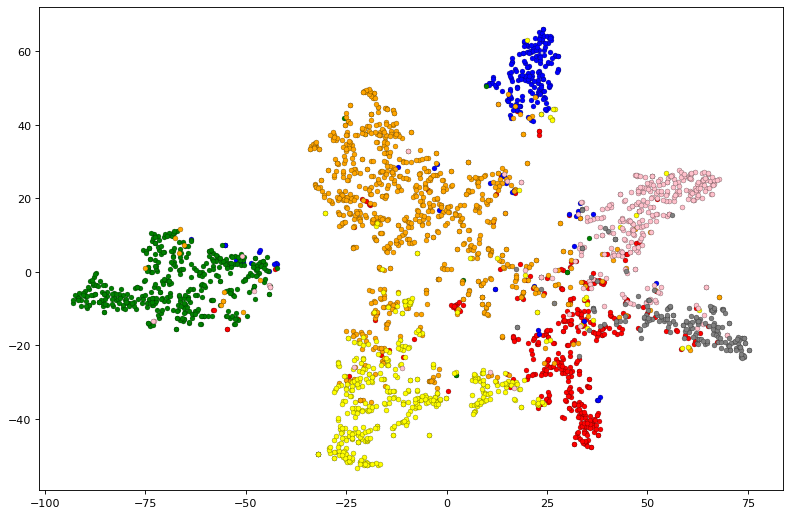

In [41]:
model_name=r'gat_000000.pth'  # This model is checked-in, feel free to use the one you trained
dataset_name = DatasetType.CORA.name

visualize_gat_properties(
    model_name,
    dataset_name,
    visualization_type=VisualizationType.EMBEDDINGS  # pick between attention, t-SNE embeddings and entropy
)

In [43]:
check_path = os.path.join(CHECKPOINTS_PATH, 'gat_ckpt_epoch_1000.pth')
check_state = torch.load(check_path)

In [49]:
check_state.keys()

dict_keys(['dataset_name', 'num_of_epochs', 'test_acc', 'num_of_layers', 'num_heads_per_layer', 'num_features_per_layer', 'add_skip_connection', 'bias', 'dropout', 'state_dict'])

In [50]:
check_state['state_dict']

OrderedDict([('gat_net.0.scoring_fn_target',
              tensor([[[ 0.0808,  0.0579, -0.0560,  0.0418,  0.0043,  0.0145,  0.0315,
                        -0.1074],
                       [ 0.0407,  0.0442,  0.0557,  0.0554,  0.0082,  0.0845,  0.0033,
                         0.0338],
                       [ 0.0628, -0.1195,  0.0137, -0.0717, -0.0947,  0.0098, -0.0533,
                         0.1232],
                       [-0.0208,  0.0047, -0.0081, -0.0338,  0.0184, -0.0330,  0.0225,
                         0.0562],
                       [ 0.0076, -0.0706, -0.0401, -0.0944, -0.0286, -0.0410,  0.0645,
                         0.0209],
                       [-0.1737, -0.1058,  0.0952, -0.0056,  0.1595,  0.0286, -0.0084,
                        -0.0218],
                       [ 0.0608, -0.0301, -0.0665, -0.0077,  0.0280,  0.0788, -0.0415,
                         0.0187],
                       [-0.0532, -0.0692, -0.0608,  0.0105, -0.0370, -0.0592,  0.0716,
                     